SHapley Additive exPlanations.

explains individual predictions

In [1]:
!pip install shap

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\mutte\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import shap
import warnings
warnings.filterwarnings('ignore')

data=pd.read_csv(r"D:\GeakMinds Internship\real world projects\datasets\housing.csv")
print("Loading Housing Data...")

Loading Housing Data...


In [3]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
np.random.seed(42)
n_samples = 1000

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
data['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [7]:
data['total_bedrooms'].isnull().sum()

207

In [8]:
mean=data['total_bedrooms'].mean()
data['total_bedrooms']=data['total_bedrooms'].fillna(mean)
data['total_bedrooms'].isnull().sum()

0

In [9]:
data.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [10]:
from sklearn.model_selection import train_test_split

x=data[['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity']]
y=data['median_house_value']

In [11]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

In [12]:
data_training=x_train.join(y_train)
data_training.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,NEAR OCEAN,103000.0
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,NEAR OCEAN,382100.0
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,NEAR OCEAN,172600.0
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,NEAR OCEAN,93400.0
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,INLAND,96500.0


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

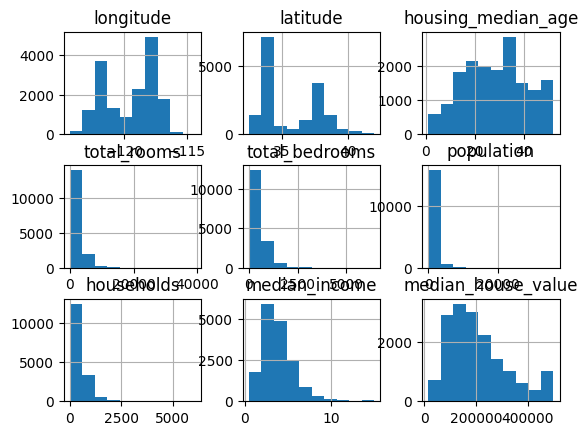

In [13]:
data_training.hist()

<Axes: >

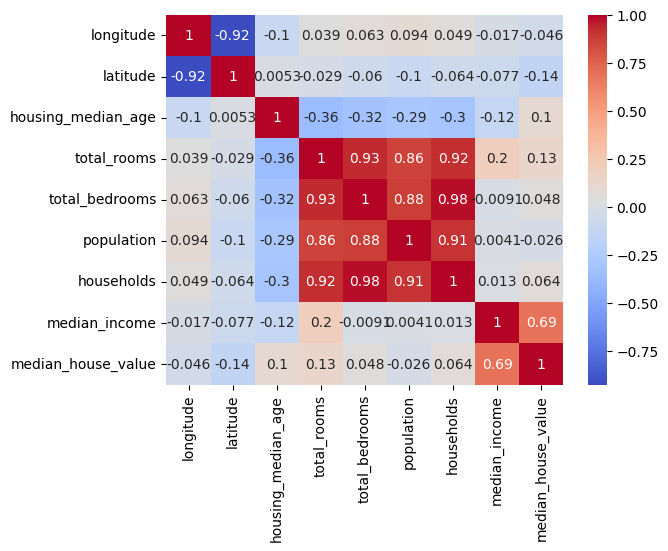

In [14]:
k=data_training.select_dtypes(include='number').corr()
sns.heatmap(k,annot=True,cmap='coolwarm')

In [15]:
data_training.select_dtypes(include='number').skew()

longitude            -0.288418
latitude              0.461504
housing_median_age    0.063453
total_rooms           4.090691
total_bedrooms        3.415689
population            5.276131
households            3.386714
median_income         1.634090
median_house_value    0.976531
dtype: float64

In [16]:
from scipy.stats import boxcox as scipy_boxcox

def boxcox(df, columns):
    lambdas = {}
    df = df.copy()
    for col in columns:
        if df[col].min() <= 0:
            shift_value = abs(df[col].min()) + 1e-6 
            df[col] = df[col] + shift_value
        df[col], fitted_lambda = scipy_boxcox(df[col])
        lambdas[col] = fitted_lambda
        
    return df

data_training=boxcox(data_training,['total_rooms','population',
'housing_median_age','households','total_bedrooms','median_income'])

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

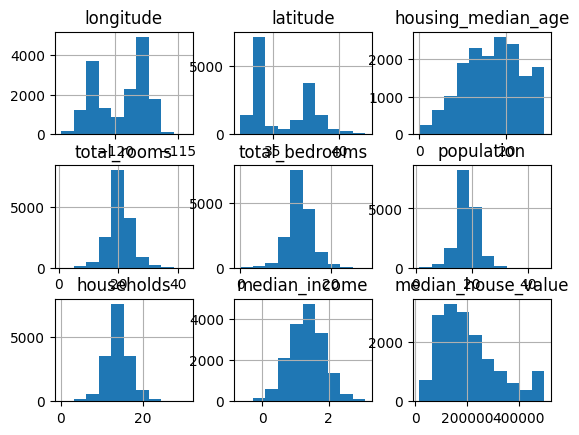

In [17]:
data_training.hist()

In [18]:
data_training.select_dtypes(include='number').skew()

longitude            -0.288418
latitude              0.461504
housing_median_age   -0.121496
total_rooms           0.121740
total_bedrooms        0.109429
population            0.113038
households            0.114522
median_income         0.005184
median_house_value    0.976531
dtype: float64

In [19]:
data_training = pd.get_dummies(data_training, columns=['ocean_proximity'])

In [20]:
data_training

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
14196,-117.03,32.71,19.554790,22.399749,14.548675,22.019217,15.752246,1.252351,103000.0,False,False,False,False,True
8267,-118.16,33.77,27.361959,22.874289,15.548915,18.776740,16.719591,1.429511,382100.0,False,False,False,False,True
17445,-120.48,34.66,2.552592,19.574413,11.997510,16.896858,12.956518,1.528298,172600.0,False,False,False,False,True
14265,-117.11,32.69,21.066249,18.077701,12.385267,19.193213,13.188692,0.685937,93400.0,False,False,False,False,True
2271,-119.80,36.78,24.502559,20.823413,13.007295,16.669951,13.480322,1.349851,96500.0,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,-117.96,33.78,20.565242,17.748160,10.246447,15.318111,11.218866,2.029242,229200.0,True,False,False,False,False
11964,-117.43,34.02,19.554790,22.319032,14.144281,20.392894,14.216371,1.178015,97800.0,False,True,False,False,False
5390,-118.38,34.03,21.066249,20.126954,14.136912,20.402812,14.952023,1.135020,222100.0,True,False,False,False,False
860,-121.96,37.58,9.771096,23.213894,14.339559,20.471876,15.230151,1.900827,283500.0,True,False,False,False,False


<Axes: >

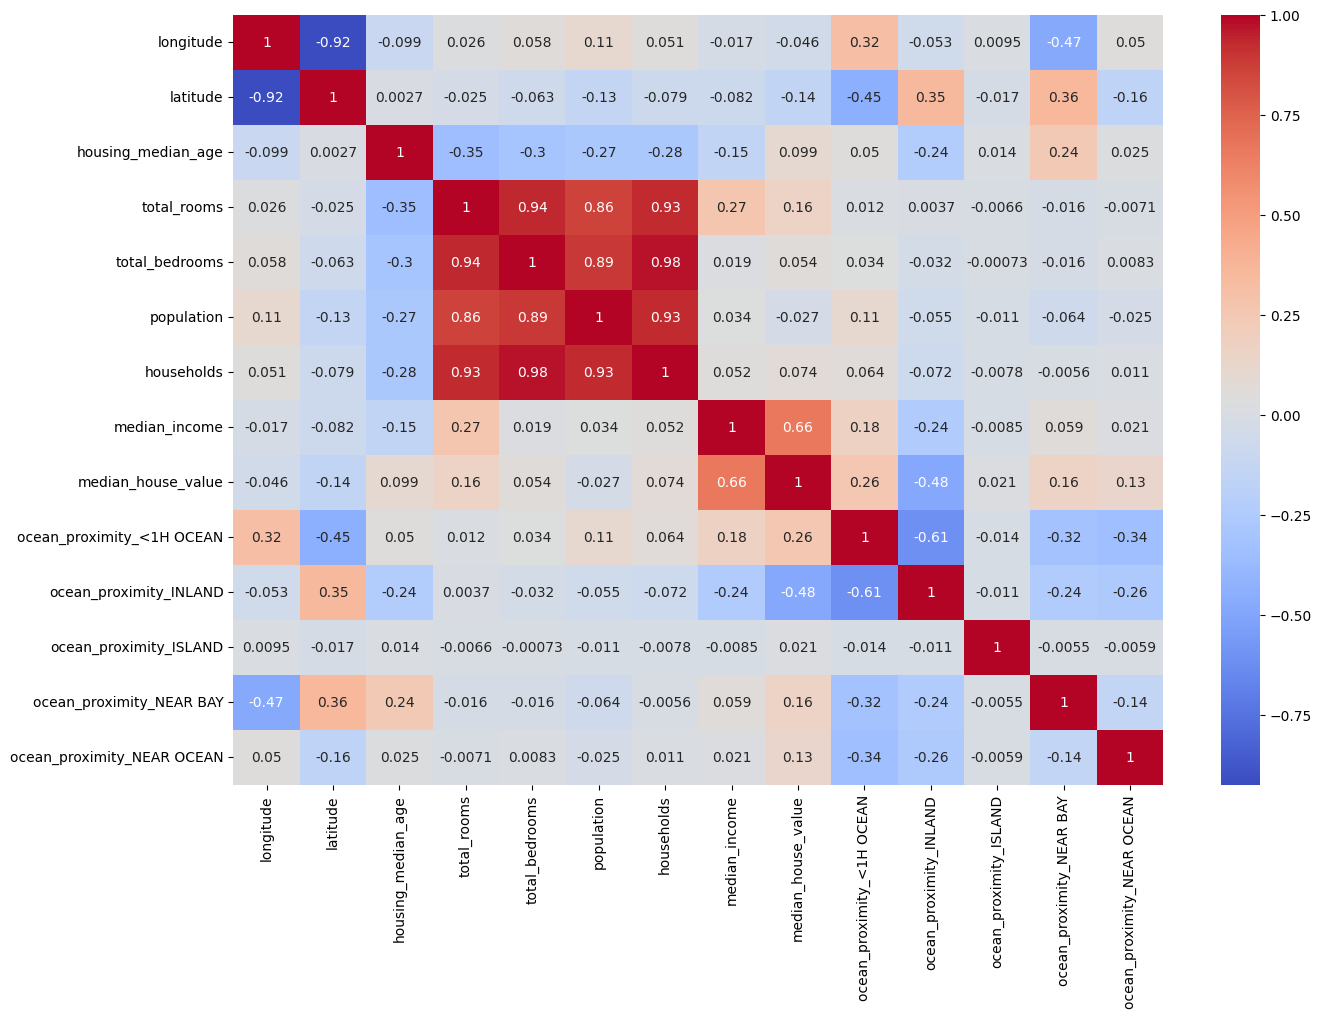

In [21]:
plt.figure(figsize=(15,10))
sns.heatmap(data_training.corr(),annot=True,cmap='coolwarm')

In [22]:
data_training['bhk_per_household'] = data_training['total_bedrooms'] / (data_training['households'] + 1e-6)
data_training['bhk_per_household']=np.log(data_training['bhk_per_household']+1.5)

In [23]:
data_training['population']=np.log(data_training['population']+1.5)

In [24]:
cols_to_drop = [

    'population', 
    'households', 
    'ocean_proximity_ISLAND', 
]

data_training = data_training.drop(columns=cols_to_drop)

x_train=data_training.drop(['median_house_value'],axis=1)
y_train=data_training['median_house_value']

In [25]:
data_testing=x_test.join(y_test)
data_testing=boxcox(data_testing,['total_rooms','population',
'housing_median_age','households','total_bedrooms','median_income'])
data_testing = pd.get_dummies(data_testing, columns=['ocean_proximity'])
data_testing['bhk_per_household'] = data_testing['total_bedrooms'] / (data_testing['households'] + 1e-6)
data_testing['bhk_per_household']=np.log(data_testing['bhk_per_household']+1.5)
data_testing['population']=np.log(data_testing['population']+1.5)
data_testing = data_testing.drop(columns=cols_to_drop)
x_test=data_testing.drop(['median_house_value'],axis=1)
y_test=data_testing['median_house_value']

In [26]:
x_test.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'median_income', 'ocean_proximity_<1H OCEAN',
       'ocean_proximity_INLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN', 'bhk_per_household'],
      dtype='object')

In [27]:
x_train.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'median_income', 'ocean_proximity_<1H OCEAN',
       'ocean_proximity_INLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN', 'bhk_per_household'],
      dtype='object')

In [28]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(random_state=42)
forest.fit(x_train,y_train)

RandomForestRegressor(random_state=42)

In [29]:
print(f"Initial model score on test set: {forest.score(x_test, y_test):.4f}")

Initial model score on test set: 0.7776


In [30]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(150, 400),
    'min_samples_split': [2, 4],
    'max_depth': [None, 4, 8]
}

random_search = RandomizedSearchCV(forest, param_distributions=param_dist,
                                   n_iter=10, cv=5, scoring='neg_mean_squared_error',
                                   n_jobs=-1, random_state=42)

random_search.fit(x_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 4, 8],
                                        'min_samples_split': [2, 4],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F084A88EC0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [31]:
print(f"Best model score on test set: {random_search.best_estimator_.score(x_test, y_test):.4f}")
print(f"Best parameters: {random_search.best_params_}")

Best model score on test set: 0.7822
Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 353}


SHAP FEATURE IMPACT ANALYSIS

In [40]:
x_train_numeric = x_train.copy()

In [42]:
for col in x_train_numeric.columns:
    x_train_numeric[col] = pd.to_numeric(x_train_numeric[col], errors='coerce')

In [43]:
x_train_numeric = x_train_numeric.fillna(0)

In [44]:
print(f"Data shape: {x_train_numeric.shape}")
print(f"Data types: {x_train_numeric.dtypes.unique()}")

Data shape: (16512, 11)
Data types: [dtype('float64') dtype('bool')]


In [45]:
sample_size = min(100, len(x_train_numeric))  # Reduced sample size for speed
x_train_sample = x_train_numeric.sample(n=sample_size, random_state=42)
print(f"Calculating SHAP values for {sample_size} samples...")

Calculating SHAP values for 100 samples...


In [46]:
background_size = min(50, len(x_train_numeric))
x_background = x_train_numeric.sample(n=background_size, random_state=42)

In [34]:
best_model = random_search.best_estimator_


In [47]:
x_background = x_background.astype('float64')
x_train_sample = x_train_sample.astype('float64')

In [48]:
explainer = shap.TreeExplainer(best_model, x_background)
shap_values = explainer.shap_values(x_train_sample)


 97%|=================== | 97/100 [00:16<00:00]       

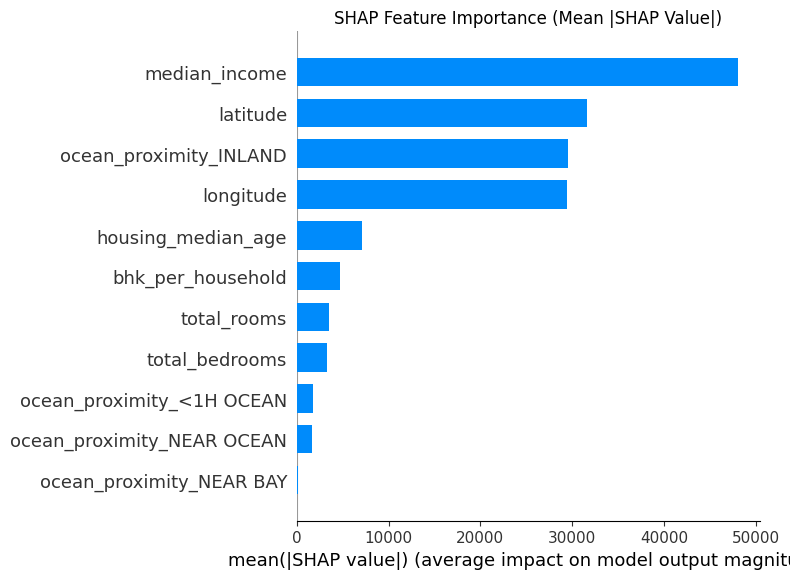

In [49]:
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, x_train_sample, plot_type="bar", show=False)
plt.title('SHAP Feature Importance (Mean |SHAP Value|)')
plt.tight_layout()
plt.show()

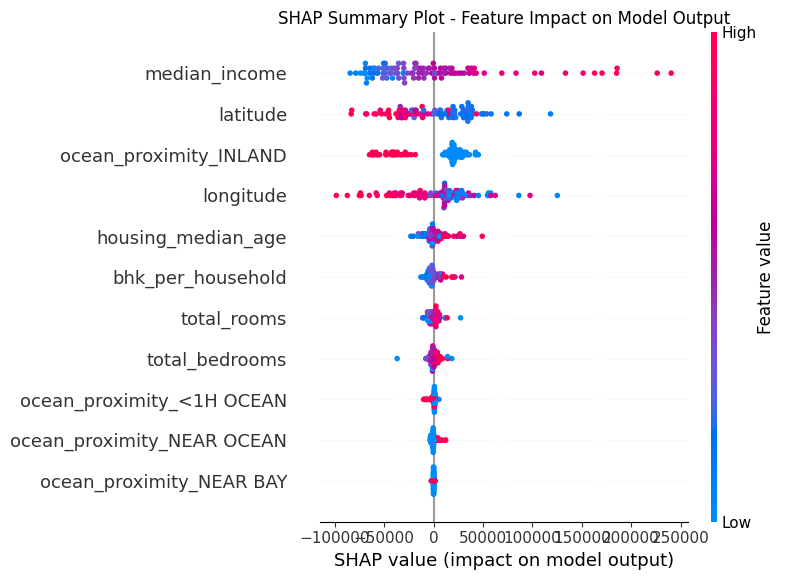

In [50]:
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, x_train_sample, show=False)
plt.title('SHAP Summary Plot - Feature Impact on Model Output')
plt.tight_layout()
plt.show()

In [51]:
feature_importance = np.abs(shap_values).mean(0)
feature_names = x_train_numeric.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\nFeature Importance Ranking:")
print(importance_df.round(4))


Feature Importance Ranking:
                       feature  importance
5                median_income  48007.1286
1                     latitude  31606.7600
7       ocean_proximity_INLAND  29554.8555
0                    longitude  29401.8891
2           housing_median_age   7068.8355
10           bhk_per_household   4698.3101
3                  total_rooms   3544.8222
4               total_bedrooms   3269.8540
6    ocean_proximity_<1H OCEAN   1727.9983
9   ocean_proximity_NEAR OCEAN   1639.1898
8     ocean_proximity_NEAR BAY    136.0763


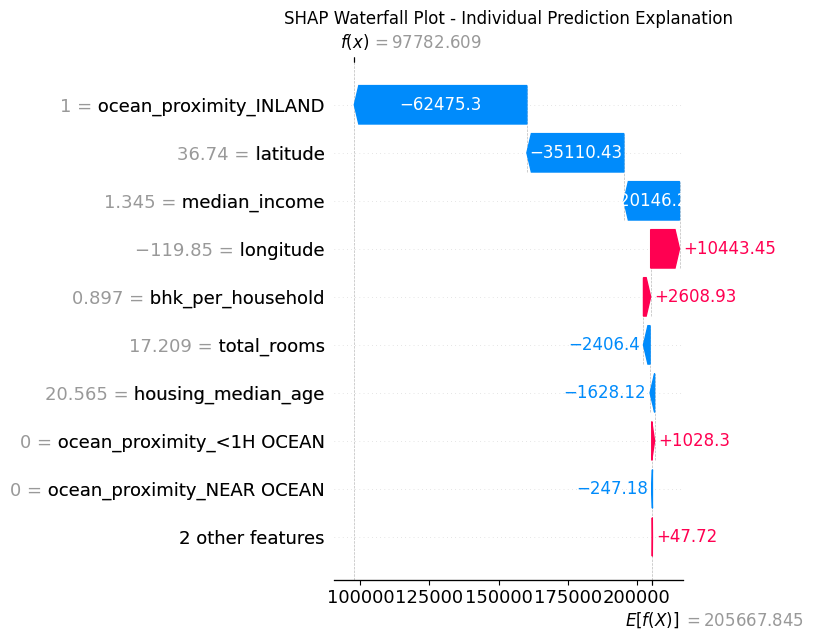

In [57]:
plt.figure(figsize=(10, 6))
shap_explanation = shap.Explanation(values=shap_values[0], 
                                   base_values=explainer.expected_value, 
                                   data=x_train_sample.iloc[0])
shap.waterfall_plot(shap_explanation, show=False)
plt.title('SHAP Waterfall Plot - Individual Prediction Explanation')
plt.tight_layout()
plt.show()


Top 3 most important features: ['median_income', 'latitude', 'ocean_proximity_INLAND']


<Figure size 800x500 with 0 Axes>

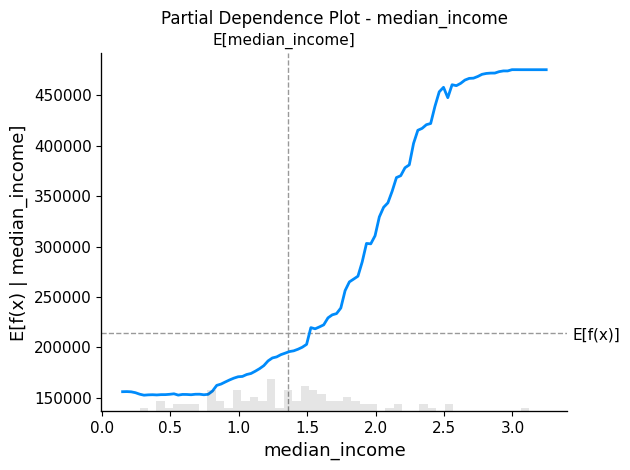

<Figure size 800x500 with 0 Axes>

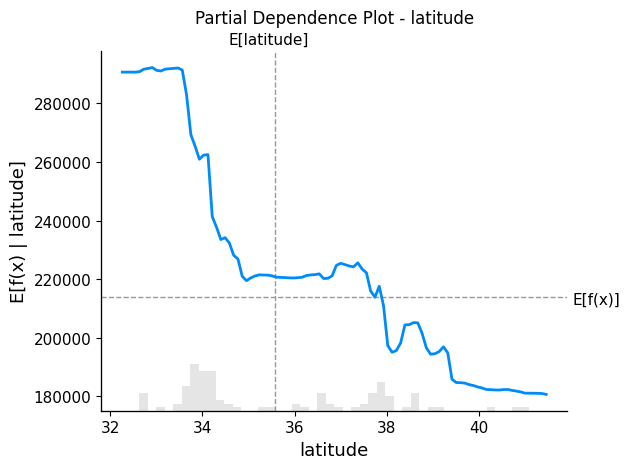

<Figure size 800x500 with 0 Axes>

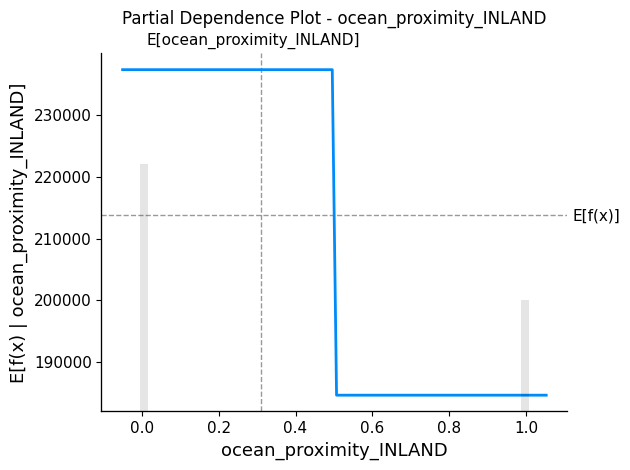

In [53]:
top_3_features = importance_df.head(3)['feature'].tolist()
print(f"\nTop 3 most important features: {top_3_features}")

for feature in top_3_features:
    plt.figure(figsize=(8, 5))
    shap.partial_dependence_plot(
        feature, best_model.predict, x_train_sample, ice=False,
        model_expected_value=True, feature_expected_value=True, show=False
    )
    plt.title(f'Partial Dependence Plot - {feature}')
    plt.tight_layout()
    plt.show()